In [2]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance,ImageDraw,ImageFont,ImageOps
# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import pickle as pkl
# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [13]:
folder_name = "breastcancerdataset"
parent_dir = os.getcwd()  # get the current working directory

# create the full path to the folder using os.path.join()
data = os.path.join(parent_dir, folder_name)
data

'd:\\Projects\\Naan_Mudhalvan\\Flask\\breastcancerdataset'

In [19]:
train_dir = data+'\\train\\'
test_dir = data+'\\test\\'
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)


In [20]:
train_dir

'd:\\Projects\\Naan_Mudhalvan\\Flask\\breastcancerdataset\\train\\'

In [21]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

([<matplotlib.patches.Wedge at 0x12964698730>,
 [Text(-1.0554261633234925, 0.30996066487903406, 'Train'),
  Text(1.0554261560683391, -0.3099606895830666, 'Test')],
 [Text(-0.5756869981764503, 0.1690694535703822, '90.9%'),
  Text(0.575686994219094, -0.16906946704530904, '9.1%')])

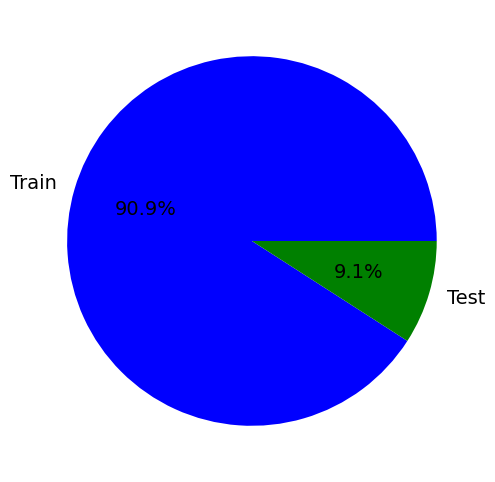

In [22]:
plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=['blue','green'], autopct='%.1f%%')
        

In [23]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    image = np.expand_dims(image, axis=-1)  # add an additional channel
    image = np.repeat(image, 3, axis=-1)  # repeat the channel to create 3 channels
    return image


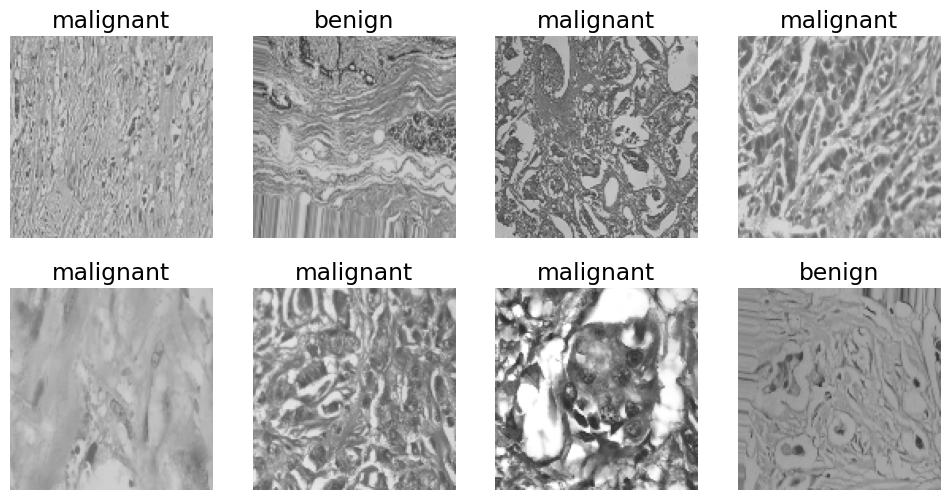

In [24]:
IMAGE_SIZE = 128

def open_images(paths):
   
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE),color_mode='grayscale')
        image = augment_image(image)
        images.append(image)
        images
    return np.array(images)

images = open_images(train_paths[1:10])
labels = train_labels[1:10]

fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [ ]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [ ]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')

# Set more layers to trainable
for layer in base_model.layers[:-6]:
    layer.trainable = False

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(unique_labels), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])


In [ ]:
batch_size = 30
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),epochs=epochs, steps_per_epoch=steps)


In [ ]:
model.save('breastcancer.h5')

In [ ]:
unique_labels = os.listdir(train_dir)
print(unique_labels)


In [ ]:
def predict_image(image_path, model):
    # Load the image
    img = Image.open(image_path)
    # Preprocess the image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
    img = np.array(img) / 255.0
    # Make predictions
    pred = model.predict(np.array([img]))
    label = unique_labels[np.argmax(pred)]
    # Add the label to the image
    img = Image.fromarray((img * 255).astype(np.uint8))
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("arial.ttf", 14)
    draw.text((6, 6), label, font=font)
    # Show the image
    img.show()
predict_image('1.png',model)